# Description

In this notebook, I will train the Federated Learning system with **ResNet architecture.**

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.random.set_seed(42)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:  tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e: print(e)

import gc
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize

from sklearn.model_selection import train_test_split

from config_celeb import *
from utils.read_data_utils import *
from utils.model_utils import *
from utils.pruning_utils import *

2024-06-07 16:32:58.436998: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 16:32:58.437015: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 16:32:58.437151: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os

# =========================================================
# Dataset Hyper-parameter
DATASET_NAME = 'celeb'  # mnist or celeb

IMAGE_DIMENSION = 84
INPUT_SHAPE = (IMAGE_DIMENSION, IMAGE_DIMENSION, 3)
OUPUT_SHAPE = 2
LABEL_NAME = {0: 'female', 1: 'male'}    # Gender classification 


# =========================================================
# Model Hyper-parameter
OPTIMIZER = 'adam'
LOSS = 'categorical_crossentropy'
METRICS = ['accuracy']

LIST_NUMBER_FILTERS = [16, 32, 64]
KERNEL_SIZE = 5
DROPOUT_RATE = 0.1
PATH_GLOBAL_MODEL = os.path.join("models", "global_model_resnet_celeb_prune.h5")


# =========================================================
# Training Hyper-parameter
NUM_ROUNDS = 500
NUM_SELECTED_CLIENT = 50

LOCAL_EPOCHS = 5
LOCAL_BATCH_SIZE = 32

IS_STILL_PRUNE = True
MAX_PRUNED_ROUND = 50
PRUNE_PATIENCE = 0
MAX_PRUNE_PATIENCE = 3

STD_THRESHOLD_PRUNE = 2.0

# 1. Dataset

## 1.1. Load dataset

In [3]:
celeb_train, celeb_test = tff.simulation.datasets.celeba.load_data()

num_clients = len(celeb_train.client_ids)
print(f"Number of clients: {num_clients}")

Number of clients: 8408


## 1.2. Prepare training dataset

In [4]:
list_clients_data = Create_Clients_Data(celeb_train, DATASET_NAME)
print(f"Number of client: {len(list_clients_data)}")

Number of client: 8408


Shape of image: (84, 84, 3)
Max value of X: 255
Min value of X: 0
Client = 10001
Label = [1. 0.]


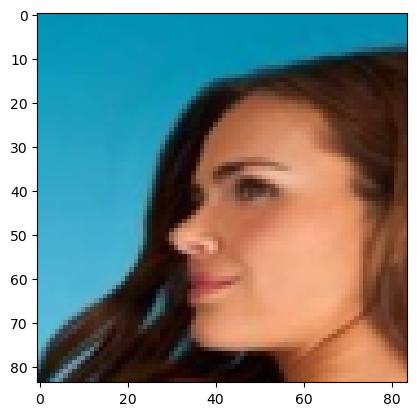

In [5]:
idx_client = np.random.randint(0, 10)
idx_sample = np.random.randint(0, 10)

client_data = list_clients_data[idx_client]

client_name = client_data['client_name']
list_X = client_data['list_X']
list_y = client_data['list_y']

X = list_X[idx_sample]
print(f"Shape of image: {X.shape}")
print(f"Max value of X: {X.max()}")
print(f"Min value of X: {X.min()}")

y = list_y[idx_sample]

print(f"Client = {client_name}")
print(f"Label = {y}")
plt.imshow(X, cmap='gray')
plt.show()

## 1.3. Prepare val - test dataset

In [6]:
list_data_test = Create_Clients_Data(celeb_test, dataset_name=DATASET_NAME)

X_test = []
y_test = []
for data_test in list_data_test:
    X_test.append(data_test['list_X'])
    y_test.append(data_test['list_y'])
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_val = np.array([resize(image, (IMAGE_DIMENSION, IMAGE_DIMENSION)) for image in X_val])
X_test = np.array([resize(image, (IMAGE_DIMENSION, IMAGE_DIMENSION)) for image in X_test])

In [7]:
print(f"Shape of X val: {X_val.shape}")
print(f"Shape of y val: {y_val.shape}")
print(f"Max value of X_val: {X_val[3].max()}")
print(f"Min value of X_val: {X_val[3].min()}")
print()
print(f"Shape of X test: {X_test.shape}")
print(f"Shape of y test: {y_test.shape}")

Shape of X val: (9929, 84, 84, 3)
Shape of y val: (9929, 2)
Max value of X_val: 1.0
Min value of X_val: 0.0

Shape of X test: (9930, 84, 84, 3)
Shape of y test: (9930, 2)


# 2. FL Training

## 2.1. Define components

In [8]:
def Define_ResNet_Model(input_shape, output_shape, list_number_filters, max_pooling_step=2, model_name=None):
    """
    This function create the simple Residual Network model. 
    """
    inputs = layers.Input(shape=input_shape)
    
    # Initial Convolutional Layer
    x = layers.Conv2D(list_number_filters[0], kernel_size=3, strides=2, padding='same', name=f'prunable_conv_0')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=max_pooling_step, strides=max_pooling_step, padding='same')(x)
    
    # Residual Blocks
    for (idx_residual_block, number_filters) in enumerate(list_number_filters[1:]):
        x = residual_block(x, num_filters_1=number_filters, num_filters_2=number_filters, strides=(2, 2), idx_residual_block=idx_residual_block)
    
    # Final Layers
    # x = layers.GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = layers.Dense(output_shape, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [9]:
keras.backend.clear_session()
global_model = Define_ResNet_Model(INPUT_SHAPE, OUPUT_SHAPE, LIST_NUMBER_FILTERS, max_pooling_step=2, model_name=None)
global_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics = METRICS)
print(f"Number of params: {global_model.count_params()}")

num_conv_layers = Count_Conv2d_Layers(global_model)
print(f"Number of Conv2D layer: {num_conv_layers}")

flops = get_flops_keras_model(global_model)
print(f"FLOPS of global model: {flops}")

plot_model(global_model, to_file=os.path.join('images', f'ResNet-{num_conv_layers}.png'), show_shapes=True, show_layer_names=True);
global_model.save(PATH_GLOBAL_MODEL)

Number of params: 30626
Number of Conv2D layer: 7
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPS of global model: 5234332

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please

/home/necphy/miniconda3/envs/fl_env/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 2.2. FL training

In [10]:
def prune_model(model, optimizer, loss_func, metrics, std_threshold=3.0):
    """
    This function take input as model and perform model pruning to return the pruned filters CNN model.

    * Parameters:
        model (keras model): input model.
        optimizer (keras optimizer).
        loss_func (keras loss function).
        metrics (keras metrics)
        std_threshold (integer): threshold to prune filters.

    * Return:
        model (keras model) -- the pruned filters model.
    """

    global IS_STILL_PRUNE
    global PRUNE_PATIENCE
    before_prune_params = model.count_params()

    list_number_filters = []
    for layer in model.layers:
        if isinstance(layer, Conv2D) and layer.name != 'classifier' and 'prunable_conv' in layer.name:
            weights = layer.get_weights()[0]
            pruned_filter = Apply_Pruning_Filter(weights, std_threshold)
            pruned_number_filter = pruned_filter.shape[-1]

            if pruned_number_filter <= 0:
                pruned_number_filter = 1
            list_number_filters.append(pruned_number_filter)

    new_model = Define_ResNet_Model(input_shape=model.input_shape[1:], output_shape=model.output_shape[1], list_number_filters=list_number_filters)
    new_model_params = new_model.count_params()
    print(f"list_number_filters: {list_number_filters}")
    print(f"before_prune_params: {before_prune_params}")
    print(f"new_model_params: {new_model_params}")

    if before_prune_params > new_model_params:
        PRUNE_PATIENCE = 0
        print(f"--- [INFO] This round PRUNE filter ---")
        new_model.compile(optimizer=optimizer, loss=loss_func, metrics=metrics)
        return new_model
    else:
        PRUNE_PATIENCE += 1
        print(f"--- [INFO] This round NOT prune filter ---")
        if PRUNE_PATIENCE >= MAX_PRUNE_PATIENCE:
            IS_STILL_PRUNE = False
            print(f"===== [INFO] Stop prune here! =====")
            print(f"Final params: {before_prune_params}")
        return model

In [11]:
NUM_CLIENTS = num_clients
list_val_acc = []
list_val_loss = []
list_model_params = []


for idx_round in range(NUM_ROUNDS):
    print("\n [INFO] Round {}".format(idx_round))

    # Load global model at begin of each round.
    global_model = keras.models.load_model(PATH_GLOBAL_MODEL)
    global_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics = METRICS)
    
    # Perform the pruning process
    if IS_STILL_PRUNE == True:
        if idx_round > MAX_PRUNED_ROUND:
            IS_STILL_PRUNE = False
            print(f"===== [INFO] Stop prune here. Final params: {global_model.count_params()}")
        elif idx_round > 0:
            global_model = prune_model(global_model, optimizer=OPTIMIZER, loss_func=LOSS, metrics=METRICS, std_threshold=STD_THRESHOLD_PRUNE)
    
    # Clients clone model from server
    client_model = keras.models.clone_model(global_model)    
    client_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

    selected_clients_data = random.sample(list_clients_data, NUM_SELECTED_CLIENT)  # Random subset clients

    # Loop through selected client
    list_client_model_weight = []
    list_client_scales = []
    for selectd_client_data in selected_clients_data:      

        # Clone client's weight from global model
        client_model.set_weights(global_model.get_weights())

        client_name = selectd_client_data['client_name']
        list_X = selectd_client_data['list_X']
        list_y = selectd_client_data['list_y']
        list_X = list_X.astype(np.float32) / 255.0
        # list_X = np.array([resize(image, (IMAGE_DIMENSION, IMAGE_DIMENSION)) for image in list_X])  # Resize input image shape

        client_model.fit(list_X, list_y, epochs=LOCAL_EPOCHS, batch_size=LOCAL_BATCH_SIZE, verbose=0)

        list_client_model_weight.append(client_model.get_weights())    # store local weight for update global model later.
        list_client_scales.append(len(list_X))
        list_X = list_y = None
        gc.collect()

    
    # Calculate scale of each client
    list_client_scales = np.array(list_client_scales)
    list_client_scales = list_client_scales / list_client_scales.sum()

    # Update the global model weights
    avg_weights = FedAvg(global_model, list_client_model_weight, list_client_scales)
    global_model.set_weights(avg_weights)

    # Evaluate model on validation data
    if idx_round % 20 == 0:
        val_loss, val_acc = global_model.evaluate(X_val, y_val, verbose=0)
        print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
        list_val_acc.append(val_acc)
        list_val_loss.append(val_loss)

    global_model.save(PATH_GLOBAL_MODEL)
    tf.keras.backend.clear_session()

    selected_clients_data = None
    list_client_model_weight = list_client_scales = None
    gc.collect()


 [INFO] Round 0
Val loss: 0.7022050023078918, Val accuracy: 0.4311612546443939

 [INFO] Round 1
list_number_filters: [16, 31, 61]
before_prune_params: 30626
new_model_params: 29454
--- [INFO] This round PRUNE filter ---

 [INFO] Round 2
list_number_filters: [16, 29, 57]
before_prune_params: 29454
new_model_params: 27696
--- [INFO] This round PRUNE filter ---

 [INFO] Round 3
list_number_filters: [16, 28, 55]
before_prune_params: 27696
new_model_params: 26817
--- [INFO] This round PRUNE filter ---

 [INFO] Round 4
list_number_filters: [16, 27, 53]
before_prune_params: 26817
new_model_params: 25938
--- [INFO] This round PRUNE filter ---

 [INFO] Round 5
list_number_filters: [15, 27, 51]
before_prune_params: 25938
new_model_params: 23762
--- [INFO] This round PRUNE filter ---

 [INFO] Round 6
list_number_filters: [14, 25, 49]
before_prune_params: 23762
new_model_params: 21148
--- [INFO] This round PRUNE filter ---

 [INFO] Round 7
list_number_filters: [14, 23, 47]
before_prune_params: 21

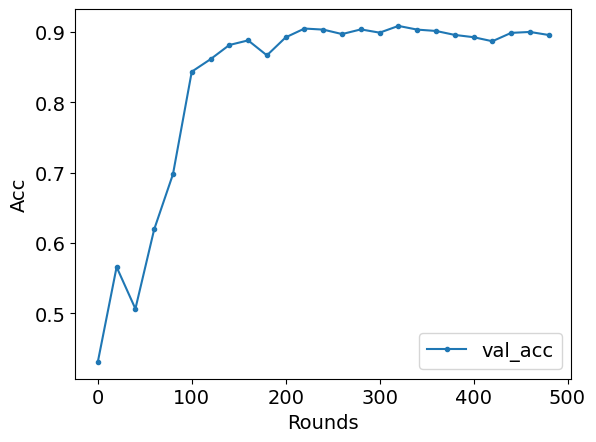

In [12]:
# Line plot for FL training
list_rounds = np.arange(0, NUM_ROUNDS, 20)

plt.rcParams.update({'font.size': 14})

plt.plot(list_rounds, list_val_acc, '.-', label='val_acc')
plt.xlabel('Rounds')
plt.ylabel('Acc')

plt.legend()
plt.show()

# 3. Evaluation

In [13]:
# X_test = np.array([resize(image, (IMAGE_DIMENSION, IMAGE_DIMENSION)) for image in X_test])
print(f"Shape of X test: {X_test.shape}")
print(f"Shape of y test: {y_test.shape}")

Shape of X test: (9930, 84, 84, 3)
Shape of y test: (9930, 2)


In [14]:
# Evaluate model on testing data
val_loss, val_acc = global_model.evaluate(X_test, y_test, verbose=0)
print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')

Val loss: 0.34053948521614075, Val accuracy: 0.8583081364631653


In [15]:
print("=== AFTER PRUNING: ==")
print(f"Number of params: {global_model.count_params()}")
flops = get_flops_keras_model(global_model).as_integer_ratio()[0]
print(f"FLOPS of global model: {flops}")


=== AFTER PRUNING: ==
Number of params: 6791
FLOPS of global model: 1610012

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
fl